In [ ]:
is_colab = False
import sys
if is_colab:
    try:
        import torch  
        print('Module torch was installed')
    except ImportError:    
        print("Installinng torch 1.8.1")
        !pip install -q torch==1.8.1
    try:
        import torchvision  
        print('Module torchvision was installed')
    except ImportError:    
        print("Installinng torchvision 0.4.0")
        !pip install -q torchvision==0.4.0
    
    try:
        import qiskit  
        print('Module qiskit was installed')
    except ImportError:    
        print("Installinng qiskit 0.14.0")
        !pip install -q qiskit==0.14.0

    !pip install JQuantumFlow==0.0.5

import torch
import torchvision
from qiskit.tools.monitor import job_monitor
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.extensions import XGate, UnitaryGate
from qiskit import Aer, execute
import qiskit



In [ ]:

from JQuantumFlow.training.lib_dataloader import load_data,to_quantum_matrix,ToQuantumData

################ Zhirui on 12-30-2020 ################
# Parameters of settings
######################################################
interest_num = [3,6]
img_size = 4
 # how many samples per batch 
batch_size = 1 
inference_batch_size = 1


################ Zhirui on 12-30-2020 ################
# path
######################################################
if is_colab:
    data_path = '/content/data' #mnist  path
else: 
    data_path = '/home/hzr/Software/quantum/qc_mnist/pytorch/data'

################ Zhirui on 12-30-2020 ################
#load data and do data preparation
######################################################

train_loader, test_loader = load_data(interest_num,data_path,False,img_size,batch_size,inference_batch_size,False)

for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix = to_quantum_matrix(data)
    to_quantum_data = ToQuantumData(img_size)
    quantum_data = to_quantum_data(data)
    break

Batch Id: 0, Target: tensor([1])


In [ ]:
################ Weiwen on 12-30-2020 ################
# Parameters of the trained model
# The training procedure will be found in another repo
# https://github.com/weiwenjiang/QuantumFlow
######################################################

# Model initialization
weight_1_1 = torch.tensor([1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,    1.,  1.])
weight_1_2 = torch.tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,-1., -1.])

weight_2_1 = torch.tensor([1.,  -1.])
norm_flag_1 = True
norm_para_1 = torch.tensor(0.3060)

weight_2_2 = torch.tensor([-1.,  -1.])
norm_flag_2 = False
norm_para_2 = torch.tensor(0.6940)

In [ ]:
################ Weiwen on 12-30-2020 ################
# Function: fire_ibmq from Listing 6
# Note: used for execute quantum circuit using 
#       simulation or ibm quantum processor
# Parameters: (1) quantum circuit; 
#             (2) number of shots;
#             (3) simulation or quantum processor;
#             (4) backend name if quantum processor.
######################################################
def fire_ibmq(circuit,shots,Simulation = False,backend_name='ibmq_essex'):     
    count_set = []
    if not Simulation:
        provider = IBMQ.get_provider('ibm-q-academic')
        backend = provider.get_backend(backend_name)
    else:
        backend = Aer.get_backend('qasm_simulator')
    job_ibm_q = execute(circuit, backend, shots=shots)
    job_monitor(job_ibm_q)
    result_ibm_q = job_ibm_q.result()
    counts = result_ibm_q.get_counts()
    return counts

################ Weiwen on 12-30-2020 ################
# Function: analyze from Listing 6
# Note: used for analyze the count on states to  
#       formulate the probability for each qubit
# Parameters: (1) counts returned by fire_ibmq; 
######################################################
def analyze(counts):
    mycount = {}
    for i in range(2):
        mycount[i] = 0
    for k,v in counts.items():
        bits = len(k) 
        for i in range(bits):            
            if k[bits-1-i] == "1":
                if i in mycount.keys():
                    mycount[i] += v
                else:
                    mycount[i] = v
    return mycount,bits

################ Weiwen on 12-30-2020 ################
# Function: cccz from Listing 3
# Note: using the basic Toffoli gates and CZ gate
#       to implement cccz gate, which will flip the
#       sign of state |1111>
# Parameters: (1) quantum circuit; 
#             (2-4) control qubits;
#             (5) target qubits;
#             (6-7) auxiliary qubits.
######################################################
def cccz(circ, q1, q2, q3, q4, aux1, aux2):
    # Apply Z-gate to a state controlled by 4 qubits
    circ.ccx(q1, q2, aux1)
    circ.ccx(q3, aux1, aux2)
    circ.cz(aux2, q4)
    # cleaning the aux bits
    circ.ccx(q3, aux1, aux2)
    circ.ccx(q1, q2, aux1)
    return circ

################ Weiwen on 12-30-2020 ################
# Function: cccz from Listing 4
# Note: using the basic Toffoli gate to implement ccccx
#       gate. It is used to switch the quantum states
#       of |11110> and |11111>.
# Parameters: (1) quantum circuit; 
#             (2-5) control qubits;
#             (6) target qubits;
#             (7-8) auxiliary qubits.
######################################################
def ccccx(circ, q1, q2, q3, q4, q5, aux1, aux2):
    circ.ccx(q1, q2, aux1)
    circ.ccx(q3, q4, aux2)
    circ.ccx(aux2, aux1, q5)
    # cleaning the aux bits
    circ.ccx(q3, q4, aux2)
    circ.ccx(q1, q2, aux1)
    return circ

################ Weiwen on 12-30-2020 ################
# Function: neg_weight_gate from Listing 3
# Note: adding NOT(X) gate before the qubits associated
#       with 0 state. For example, if we want to flip 
#       the sign of |1101>, we add X gate for q2 before
#       the cccz gate, as follows.
#       --q3-----|---
#       --q2----X|X--
#       --q1-----|---
#       --q0-----z---
# Parameters: (1) quantum circuit; 
#             (2) all qubits, say q0-q3;
#             (3) the auxiliary qubits used for cccz
#             (4) states, say 1101
######################################################
def neg_weight_gate(circ,qubits,aux,state):
    idx = 0
    # The index of qubits are reversed in terms of states.
    # As shown in the above example: we put X at q2 not the third position.
    state = state[::-1]
    for idx in range(len(state)):
        if state[idx]=='0':
            circ.x(qubits[idx])
    cccz(circ,qubits[0],qubits[1],qubits[2],qubits[3],aux[0],aux[1])
    for idx in range(len(state)):
        if state[idx]=='0':
            circ.x(qubits[idx])


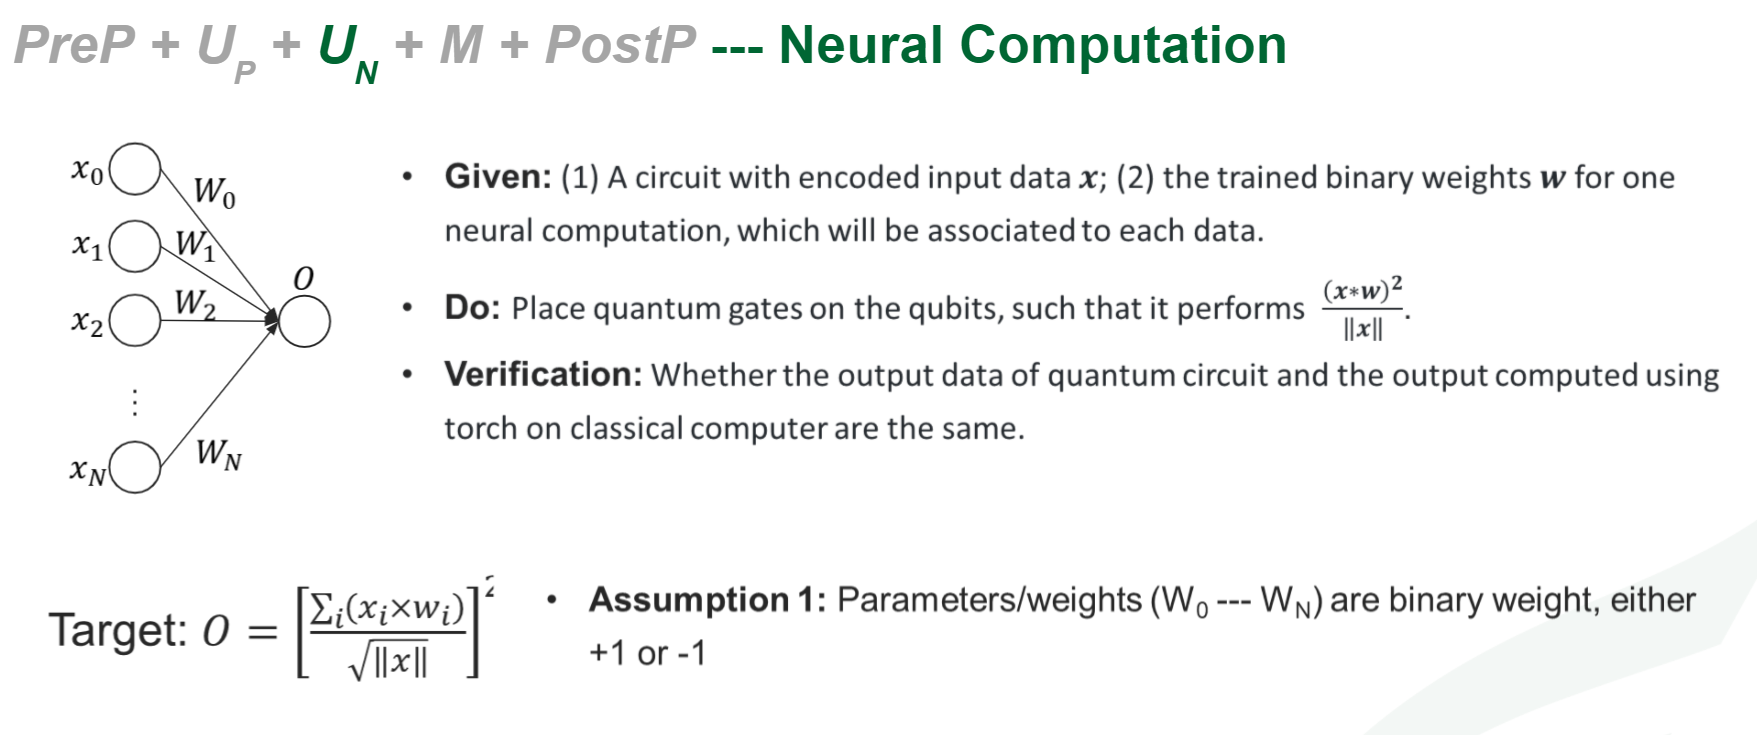

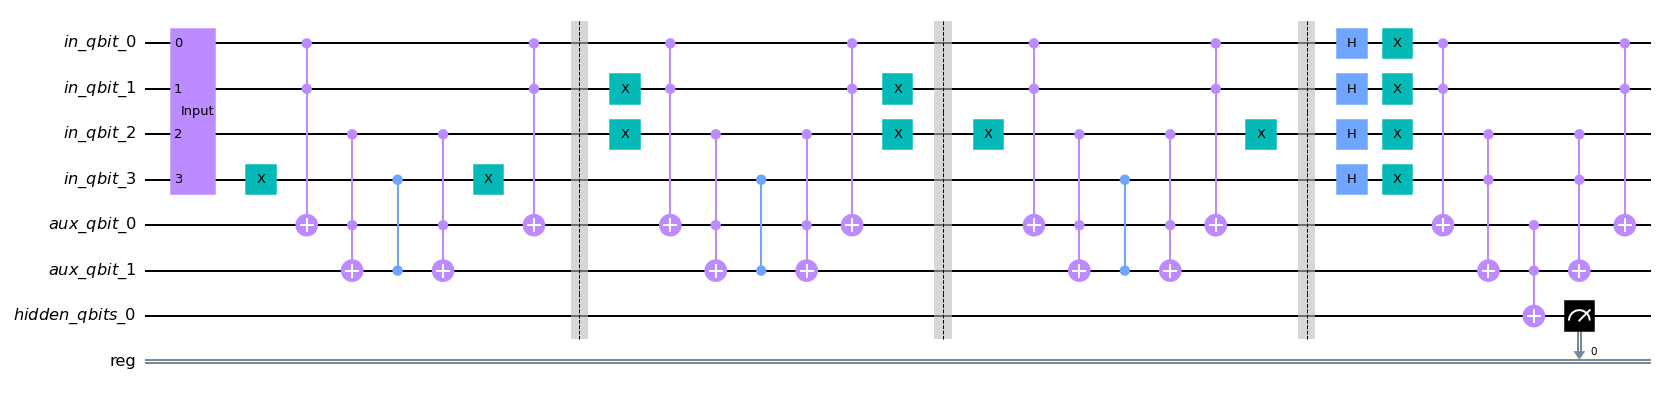

In [ ]:
################ Weiwen on 12-30-2020 ################
# Quantum circuit implementation
######################################################

# From Listing 2: creat the qubits to hold data
inp = QuantumRegister(4,"in_qbit")
circ = QuantumCircuit(inp)
data_matrix = quantum_matrix
circ.append(UnitaryGate(data_matrix, label="Input"), inp[0:4])

# From Listing 3: create auxiliary qubits
aux = QuantumRegister(2,"aux_qbit")
circ.add_register(aux)

# From Listing 4: create output qubits for the first layer (hidden neurons)
hidden_neurons = QuantumRegister(1,"hidden_qbits")
circ.add_register(hidden_neurons)

# Add classical register
c_reg = ClassicalRegister(1,"reg")
circ.add_register(c_reg)




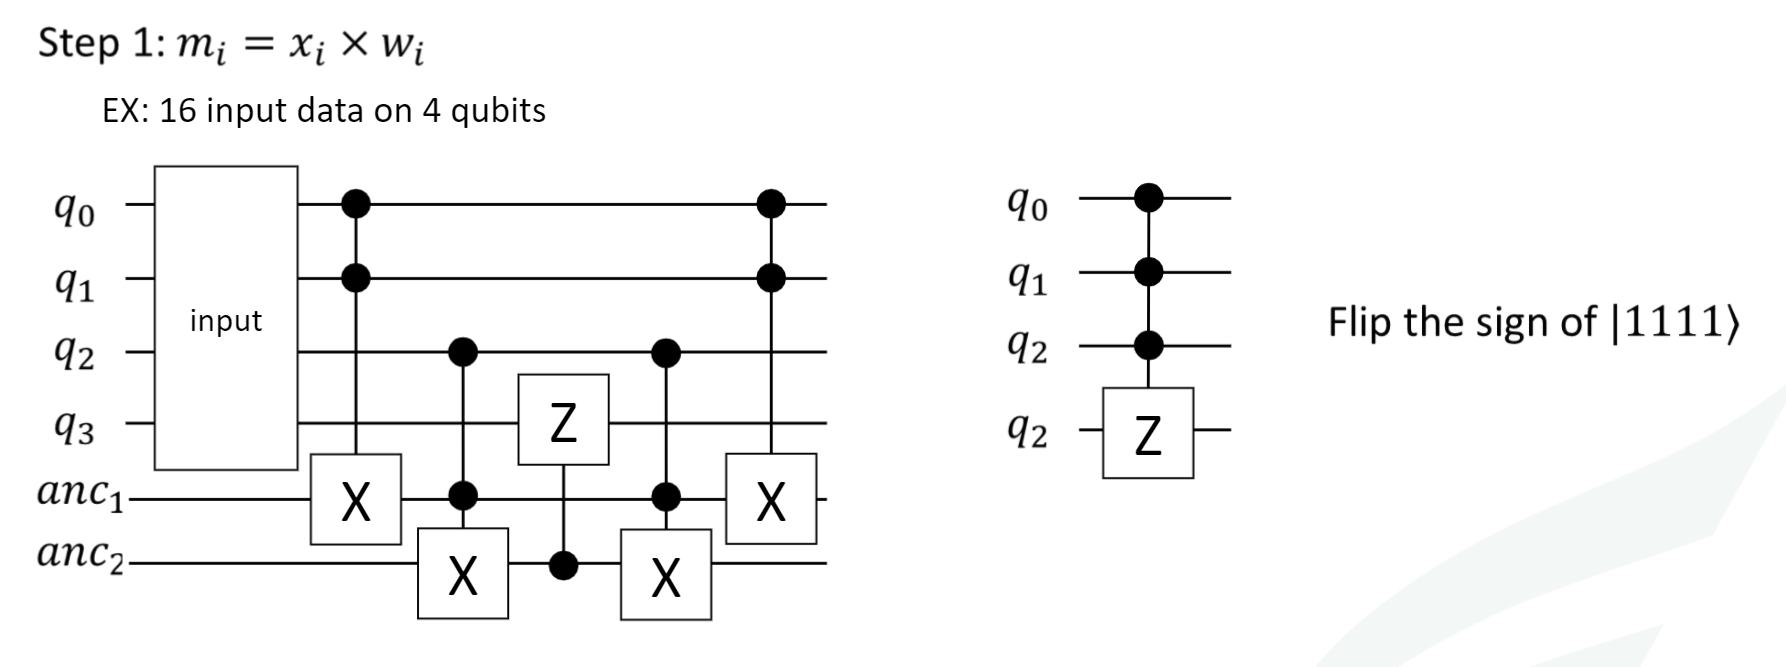

In [ ]:

# From Listing 3: to multiply inputs and weights on quantum circuit
if weight_1_1.sum()<0:
    weight_1_1 = weight_1_1*-1
idx = 0
for idx in range(weight_1_1.flatten().size()[0]):
    if weight_1_1[idx]==-1:
        state = "{0:b}".format(idx).zfill(4)
        neg_weight_gate(circ,inp,aux,state)
        circ.barrier()
    
#show your circuit
if is_colab:
    layout = 'text'
    fold = 300
else:
    layout = 'mpl'
    fold = 50

circ.draw(layout,fold=fold)

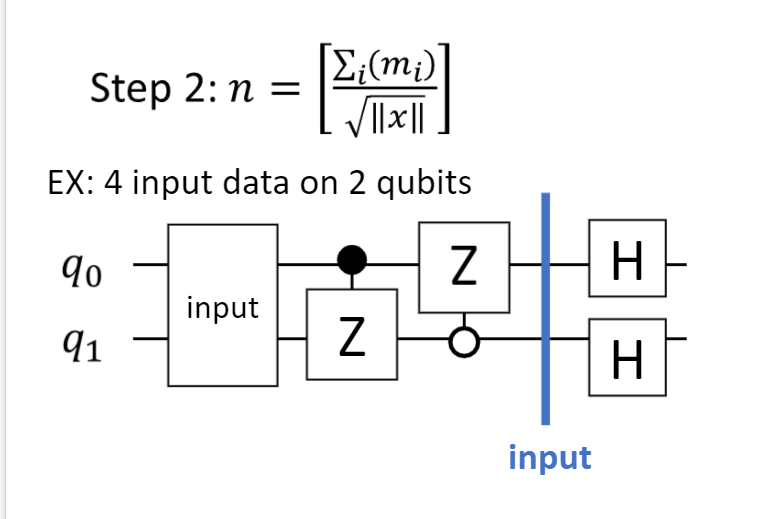

In [ ]:
# From Listing 4: applying the quadratic function on the weighted sum
circ.h(inp)
circ.x(inp)
ccccx(circ,inp[0],inp[1],inp[2],inp[3],hidden_neurons[0],aux[0],aux[1])



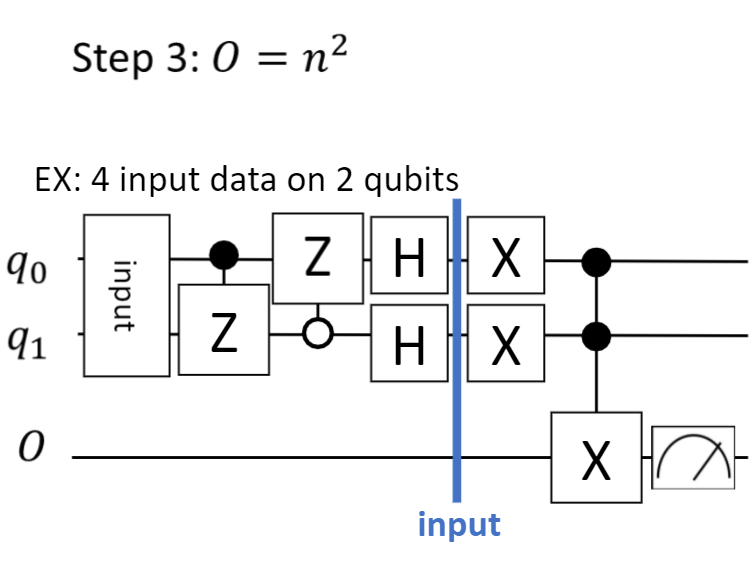

In [ ]:
# Measure output of the neuron to see the result, which is not necessary for multi-layer network
circ.measure(hidden_neurons,c_reg)

#show your circuit
if is_colab:
    layout = 'text'
    fold = 300
else:
    layout = 'mpl'
    fold = 50

circ.draw(layout,fold=fold)

In [ ]:
################ Weiwen on 12-30-2020 ################
# Quantum simulation
######################################################

# From Listing 6: execute the quantum circuit to obtain the results
qc_shots=1000000
counts = fire_ibmq(circ,qc_shots,True)
(mycount,bits) = analyze(counts)
class_prob=[]
for b in range(bits):
    class_prob.append(float(mycount[b])/qc_shots)
print(class_prob)

Job Status: job has successfully run
[0.100452]


In [ ]:
################ Weiwen on 12-30-2020 ################
# Do the same compuation in classical computing for
# comparison.
######################################################

input_data = quantum_data.flatten()
weight_neuron_1 = weight_1_1
weighted_sum_neuron_1 = (input_data*weight_neuron_1).sum()
result_neuron_1 = weighted_sum_neuron_1.pow(2)/len(weight_neuron_1)

print([result_neuron_1])

[tensor(0.1006)]
